## **Setup environment**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
import os
import datetime
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import class_weight

np.random.seed(42)
tf.random.set_seed(42)


2.4.0


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

# **3.1: TUNE A PRETRAINED NETWORK FOR MASSES AND CALCIFICATION DIAGNOSIS**



## **Prepare Learning Dataset**





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
 
grayscale_images, labels= load_training()
images = np.repeat(grayscale_images[..., np.newaxis], 3, -1)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

grayscale_test_images, test_labels = load_test()
test_images = np.repeat(grayscale_test_images[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

Training set loaded
Images:(5352, 150, 150, 3)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Extract all abnormalities indexes
abn_indexes = np.where(labels != 0)

#Extract all anormalities images
abn_images = images[abn_indexes]
abn_labels = labels[abn_indexes]

#Change labels according to Mass and Calcification
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 2), 0, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 3, abn_labels == 4), 1, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)
total_train=np.size(train_images,0)
train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
total_val=np.size(validation_images,0)
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()


print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")


Training/Validation set split.
Train Images:(2140, 150, 150, 3)
Train Labels:(2140,)
961 belonging to class 0 in the training set
1179 belonging to class 1 in the training set

Validation Images:(536, 150, 150, 3)
Validation Labels:(536,)
257 belonging to class 0 in the validation set
279 belonging to class 1 in the validation set


In [ ]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Mass and Calcification
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 2), 0, test_labels)
test_labels = np.where(np.logical_or(test_labels == 3, test_labels == 4), 1, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 150, 150, 3)
Test Labels:(336,)
179 belonging to class 0 in the test set
157 belonging to class 1 in the test set


In [ ]:
#Data Preprocessing
BATCH_SIZE = 32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    #brightness_range=[0.6,1.2],
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'    
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)


train_dataset = train_datagen.flow(
    train_images, 
    train_labels,
    batch_size=BATCH_SIZE,
    shuffle = True
)

validation_dataset = test_datagen.flow(
    validation_images, 
    validation_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE,
    shuffle = False
)

## **3.1.1: VGG16**

### Feature Extraction

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)                
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#Name the model 
network_name = 'VGG16_featextraction3.h5'
network_name_best = 'VGG16_featextraction_best3.h5'

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 8),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/100
66/66 [==============================] - 12s 179ms/step - loss: 1.1300 - acc: 0.5527 - val_loss: 0.5236 - val_acc: 0.8027
Epoch 2/100
66/66 [==============================] - 12s 180ms/step - loss: 0.5661 - acc: 0.6895 - val_loss: 0.4792 - val_acc: 0.7852
Epoch 3/100
66/66 [==============================] - 12s 179ms/step - loss: 0.5354 - acc: 0.7199 - val_loss: 0.4502 - val_acc: 0.8418
Epoch 4/100
66/66 [==============================] - 12s 179ms/step - loss: 0.5015 - acc: 0.7620 - val_loss: 0.5125 - val_acc: 0.7227
Epoch 5/100
66/66 [==============================] - 12s 178ms/step - loss: 0.4795 - acc: 0.7647 - val_loss: 0.4195 - val_acc: 0.8535
Epoch 6/100
66/66 [==============================] - 12s 181ms/step - loss: 0.4710 - acc: 0.7800 - val_loss: 0.3974 - val_acc: 0.8535
Epoch 7/100
66/66 [==============================] - 12s 182ms/step - loss: 0.4593 - acc: 0.7802 - val_loss: 0.4130 - val_acc: 0.8477
Epoch 8/100
66/66 [==============================] - 12s 180ms

### MODEL EVALUATION (VGG16-FE)

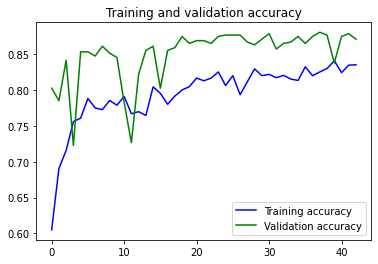

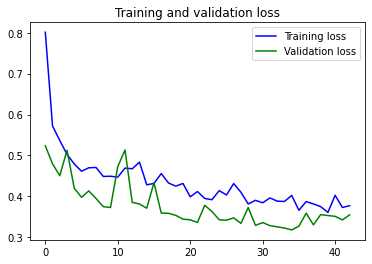

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

6/6 [==============================] - 2s 103ms/step - loss: 0.3767 - acc: 0.8363
0.836309552192688
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       179
           1       0.79      0.88      0.83       157

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336



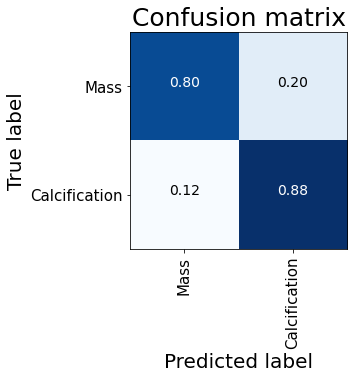

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

6/6 [==============================] - 1s 103ms/step - loss: 0.3530 - acc: 0.8363
0.836309552192688
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       179
           1       0.83      0.82      0.82       157

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336



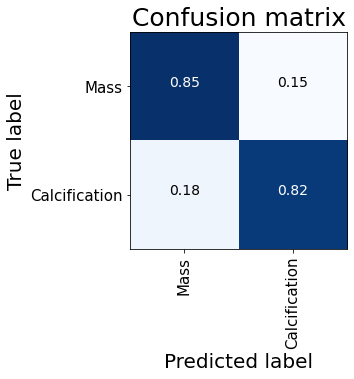

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

###Fine Tuning


In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    elif layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc/VGG16_finetuning_best.h5'

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 17,174,529
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=200,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/200
33/33 [==============================] - 14s 385ms/step - loss: 1.6246 - acc: 0.6415 - val_loss: 0.4892 - val_acc: 0.8086
Epoch 2/200
33/33 [==============================] - 13s 379ms/step - loss: 0.5036 - acc: 0.7773 - val_loss: 0.4188 - val_acc: 0.7930
Epoch 3/200
33/33 [==============================] - 13s 383ms/step - loss: 0.4635 - acc: 0.7861 - val_loss: 0.3085 - val_acc: 0.8770
Epoch 4/200
33/33 [==============================] - 13s 380ms/step - loss: 0.3709 - acc: 0.8436 - val_loss: 0.3135 - val_acc: 0.8730
Epoch 5/200
33/33 [==============================] - 12s 375ms/step - loss: 0.4209 - acc: 0.8034 - val_loss: 0.2666 - val_acc: 0.8945
Epoch 6/200
33/33 [==============================] - 13s 389ms/step - loss: 0.3771 - acc: 0.8403 - val_loss: 0.2615 - val_acc: 0.8926
Epoch 7/200
33/33 [==============================] - 13s 393ms/step - loss: 0.3756 - acc: 0.8321 - val_loss: 0.3354 - val_acc: 0.8750
Epoch 8/200
33/33 [==============================] - 12s 375ms

### MODEL EVALUATION (VGG16-FT)

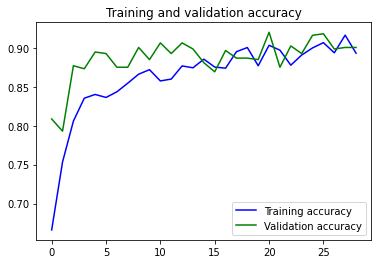

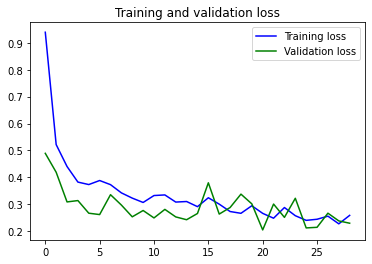

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

6/6 [==============================] - 1s 105ms/step - loss: 0.3137 - acc: 0.8839
0.8839285969734192
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       179
           1       0.86      0.90      0.88       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336



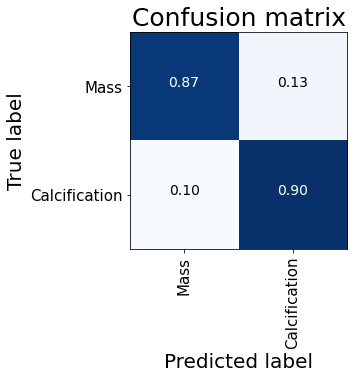

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

6/6 [==============================] - 1s 99ms/step - loss: 0.3046 - acc: 0.8869
0.886904776096344
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       179
           1       0.88      0.88      0.88       157

    accuracy                           0.89       336
   macro avg       0.89      0.89      0.89       336
weighted avg       0.89      0.89      0.89       336



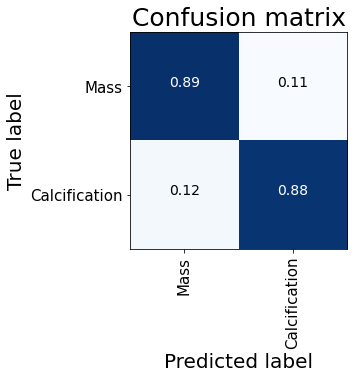

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, 'VGG16_finetuning_best.h5'))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'VGG16_finetuned2.h5'))

## 3.1.2 VGG19

### Feature Extraction




In [ ]:
conv_base19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base19.trainable = False
model19 = models.Sequential()
model19.add(conv_base19)                
model19.add(layers.Flatten())
model19.add(layers.Dense(512, activation='relu'))
model19.add(layers.Dropout(0.3))
model19.add(layers.Dense(1, activation='sigmoid'))

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
#Name the model 
network_name = 'VGG19_featextraction.h5'
network_name_best = 'VGG19_featextraction_best.h5'

In [ ]:
model19.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 8),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
conv_base19.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model19.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 24,219,713
Trainable params: 4,195,329
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#Train the model
history19 = model19.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/100
66/66 [==============================] - 13s 193ms/step - loss: 0.8162 - acc: 0.6119 - val_loss: 0.4953 - val_acc: 0.7695
Epoch 2/100
66/66 [==============================] - 13s 191ms/step - loss: 0.4942 - acc: 0.7371 - val_loss: 0.4380 - val_acc: 0.8125
Epoch 3/100
66/66 [==============================] - 12s 189ms/step - loss: 0.4503 - acc: 0.8003 - val_loss: 0.6716 - val_acc: 0.6387
Epoch 4/100
66/66 [==============================] - 12s 184ms/step - loss: 0.4831 - acc: 0.7571 - val_loss: 0.5201 - val_acc: 0.6973
Epoch 5/100
66/66 [==============================] - 12s 185ms/step - loss: 0.4650 - acc: 0.7700 - val_loss: 0.4101 - val_acc: 0.8379
Epoch 6/100
66/66 [==============================] - 13s 191ms/step - loss: 0.4220 - acc: 0.8096 - val_loss: 0.4075 - val_acc: 0.7969
Epoch 7/100
66/66 [==============================] - 12s 187ms/step - loss: 0.3976 - acc: 0.8166 - val_loss: 0.3700 - val_acc: 0.8496
Epoch 8/100
66/66 [==============================] - 13s 190ms

### MODEL EVALUATION (VGG19-FE)



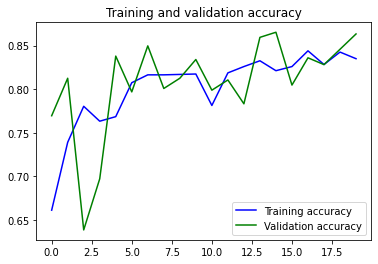

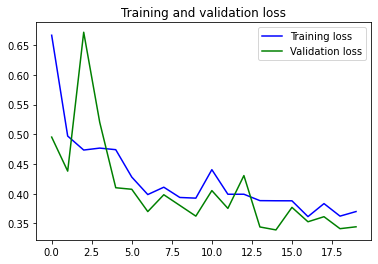

In [ ]:
import matplotlib.pyplot as plt

acc = history19.history['acc']
val_acc = history19.history['val_acc']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 1s 85ms/step - loss: 0.3924 - acc: 0.8393
0.8392857313156128
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       179
           1       0.88      0.76      0.82       157

    accuracy                           0.84       336
   macro avg       0.84      0.83      0.84       336
weighted avg       0.84      0.84      0.84       336



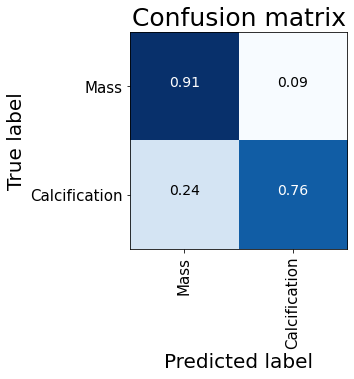

In [ ]:
test_loss, test_accuracy = model19.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model19.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model19.save(os.path.join(dir_name, network_name))

11/11 [==============================] - 1s 83ms/step - loss: 0.3868 - acc: 0.8274
0.8273809552192688
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       179
           1       0.80      0.83      0.82       157

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336



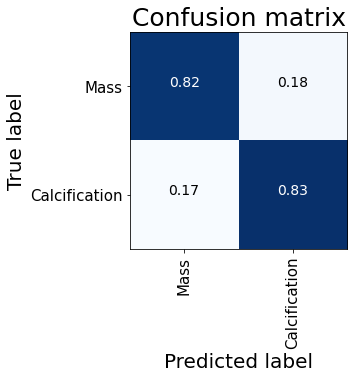

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

### Fine Tuning


In [ ]:
conv_base19.trainable = True

set_trainable = False
for layer in conv_base19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    elif layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model19.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
conv_base19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model19.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 24,219,713
Trainable params: 21,894,145
Non-trainable params: 2,325,568
_________________________________________________________________


In [ ]:
history19 = model19.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=50,
      validation_data = validation_dataset,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 8)]
      )

Epoch 1/50
67/67 [==============================] - 17s 234ms/step - loss: 0.7864 - acc: 0.6943 - val_loss: 0.3333 - val_acc: 0.8713
Epoch 2/50
67/67 [==============================] - 15s 217ms/step - loss: 0.4096 - acc: 0.8004 - val_loss: 0.3142 - val_acc: 0.8601
Epoch 3/50
67/67 [==============================] - 15s 216ms/step - loss: 0.3502 - acc: 0.8452 - val_loss: 0.2701 - val_acc: 0.8862
Epoch 4/50
67/67 [==============================] - 14s 214ms/step - loss: 0.3376 - acc: 0.8476 - val_loss: 0.3326 - val_acc: 0.8377
Epoch 5/50
67/67 [==============================] - 14s 215ms/step - loss: 0.3045 - acc: 0.8631 - val_loss: 0.2614 - val_acc: 0.9030
Epoch 6/50
67/67 [==============================] - 15s 217ms/step - loss: 0.2791 - acc: 0.8787 - val_loss: 0.4471 - val_acc: 0.8004
Epoch 7/50
67/67 [==============================] - 15s 216ms/step - loss: 0.2888 - acc: 0.8876 - val_loss: 0.2823 - val_acc: 0.9011
Epoch 8/50
67/67 [==============================] - 15s 216ms/step - 

### MODEL EVALUATION (VGG19-FT)

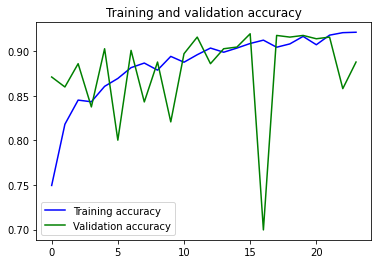

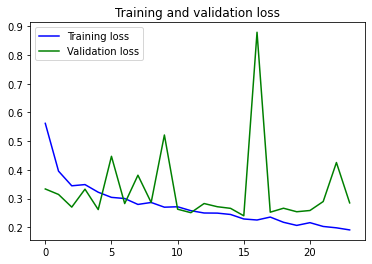

In [ ]:
import matplotlib.pyplot as plt

acc = history19.history['acc']
val_acc = history19.history['val_acc']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model19.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model19.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model19.save(os.path.join(dir_name, 'VGG19_finetuned.h5'))

# **3.2: TUNE A PRETRAINED NETWORK FOR BENIGN AND MALIGNANT DIAGNOSIS**



## Prepare Learning Dataset





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
 
grayscale_images, labels= load_training()
images = np.repeat(grayscale_images[..., np.newaxis], 3, -1)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

grayscale_test_images, test_labels = load_test()
test_images = np.repeat(grayscale_test_images[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

Training set loaded
Images:(5352, 150, 150, 3)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Extract all abnormalities indexes
abn_indexes = np.where(labels != 0)

#Extract all anormalities images
abn_images = images[abn_indexes]
abn_labels = labels[abn_indexes]

#Change labels according to Benign and Malignant
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 3), 1, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 2, abn_labels == 4), 0, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)

total_train=np.size(train_images,0)
train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
total_val=np.size(validation_images,0)
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()


print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")


Training/Validation set split.
Train Images:(2140, 150, 150, 3)
Train Labels:(2140,)
888 belonging to class 0 in the training set
1252 belonging to class 1 in the training set

Validation Images:(536, 150, 150, 3)
Validation Labels:(536,)
220 belonging to class 0 in the validation set
316 belonging to class 1 in the validation set


In [ ]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Benign and Malignant
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 3), 1, test_labels)
test_labels = np.where(np.logical_or(test_labels == 2, test_labels == 4), 0, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 150, 150, 3)
Test Labels:(336,)
117 belonging to class 0 in the test set
219 belonging to class 1 in the test set


In [ ]:
#Data Preprocessing
BATCH_SIZE = 64


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'    
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)


train_dataset = train_datagen.flow(
    train_images, 
    train_labels,
    batch_size=BATCH_SIZE,
    shuffle = True
)

validation_dataset = test_datagen.flow(
    validation_images, 
    validation_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE,
    shuffle = False
)

## **3.2.1: VGG16**

### Feature Extraction

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)                
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Name the model 
network_name = 'VGG16_featextraction.h5'
network_name_best = 'VGG16_featextraction_best.h5'

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 50),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=1000,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

### MODEL EVALUATION (VGG16-FE)

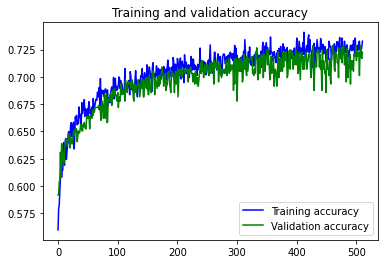

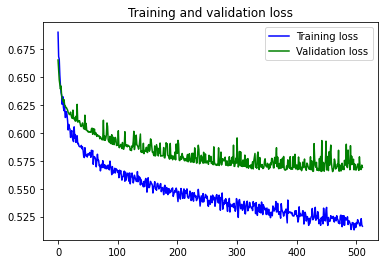

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

6/6 [==============================] - 1s 99ms/step - loss: 0.5880 - acc: 0.6994
0.699404776096344
[[ 65  52]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       117
           1       0.77      0.78      0.77       219

    accuracy                           0.70       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.70      0.70       336



In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")


###Fine Tuning


In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    elif layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-7),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 17,174,529
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)]
      )

Epoch 1/100
33/33 [==============================] - 14s 380ms/step - loss: 0.5257 - acc: 0.7345 - val_loss: 0.5730 - val_acc: 0.7168
Epoch 2/100
33/33 [==============================] - 12s 370ms/step - loss: 0.5024 - acc: 0.7510 - val_loss: 0.5700 - val_acc: 0.7207
Epoch 3/100
33/33 [==============================] - 12s 371ms/step - loss: 0.5266 - acc: 0.7114 - val_loss: 0.5730 - val_acc: 0.7148
Epoch 4/100
33/33 [==============================] - 12s 371ms/step - loss: 0.5249 - acc: 0.7183 - val_loss: 0.5730 - val_acc: 0.7129
Epoch 5/100
33/33 [==============================] - 12s 371ms/step - loss: 0.5199 - acc: 0.7304 - val_loss: 0.5729 - val_acc: 0.7168
Epoch 6/100
33/33 [==============================] - 12s 379ms/step - loss: 0.5326 - acc: 0.7278 - val_loss: 0.5697 - val_acc: 0.7188
Epoch 7/100
33/33 [==============================] - 12s 373ms/step - loss: 0.5010 - acc: 0.7536 - val_loss: 0.5707 - val_acc: 0.7148
Epoch 8/100
33/33 [==============================] - 12s 375ms

### MODEL EVALUATION (VGG16-FT)

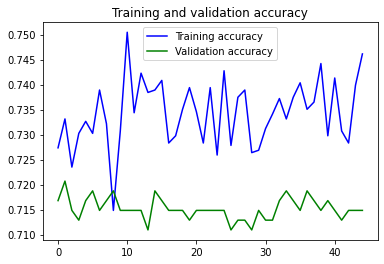

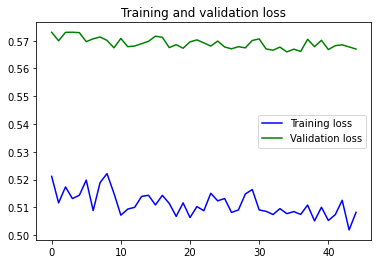

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'VGG16_finetuned.h5'))

## 3.2.2 VGG19


### Feature Extraction




In [ ]:
conv_base19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base19.trainable = False
model19 = models.Sequential()
model19.add(conv_base19)                
model19.add(layers.Flatten())
model19.add(layers.Dense(512, activation='relu'))
model19.add(layers.Dropout(0.2))
model19.add(layers.Dense(1, activation='sigmoid'))

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
#Name the model 
network_name = 'VGG19_featextraction2.h5'
network_name_best = 'VGG19_featextraction_best2.h5'

In [ ]:
model19.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 50),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
conv_base19.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 24,219,713
Trainable params: 4,195,329
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#Train the model
history19 = model19.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=1000,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      callbacks=[my_callback]
      )

Epoch 1/1000
33/33 [==============================] - 21s 374ms/step - loss: 0.6979 - acc: 0.5609 - val_loss: 0.6648 - val_acc: 0.5996
Epoch 2/1000
33/33 [==============================] - 12s 355ms/step - loss: 0.6817 - acc: 0.5605 - val_loss: 0.6598 - val_acc: 0.6172
Epoch 3/1000
33/33 [==============================] - 12s 357ms/step - loss: 0.6644 - acc: 0.5869 - val_loss: 0.6493 - val_acc: 0.6055
Epoch 4/1000
33/33 [==============================] - 12s 357ms/step - loss: 0.6585 - acc: 0.5824 - val_loss: 0.6432 - val_acc: 0.6191
Epoch 5/1000
33/33 [==============================] - 12s 360ms/step - loss: 0.6512 - acc: 0.6098 - val_loss: 0.6395 - val_acc: 0.6230
Epoch 6/1000
33/33 [==============================] - 12s 359ms/step - loss: 0.6352 - acc: 0.6321 - val_loss: 0.6355 - val_acc: 0.6289
Epoch 7/1000
33/33 [==============================] - 12s 360ms/step - loss: 0.6288 - acc: 0.6507 - val_loss: 0.6343 - val_acc: 0.6230
Epoch 8/1000
33/33 [==============================] - 1

### MODEL EVALUATION (VGG19-FE)

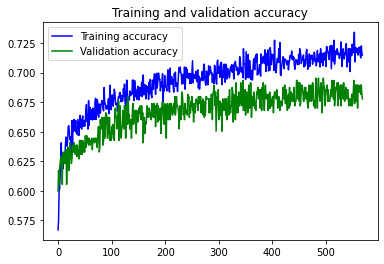

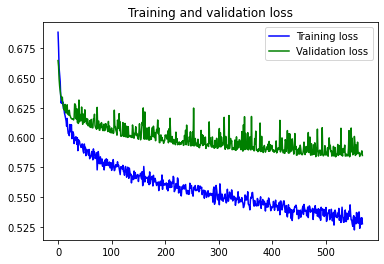

In [ ]:
import matplotlib.pyplot as plt

acc = history19.history['acc']
val_acc = history19.history['val_acc']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

6/6 [==============================] - 1s 226ms/step - loss: 0.6304 - acc: 0.6458
0.6458333134651184
              precision    recall  f1-score   support

           0       0.49      0.63      0.55       117
           1       0.77      0.65      0.71       219

    accuracy                           0.65       336
   macro avg       0.63      0.64      0.63       336
weighted avg       0.67      0.65      0.65       336



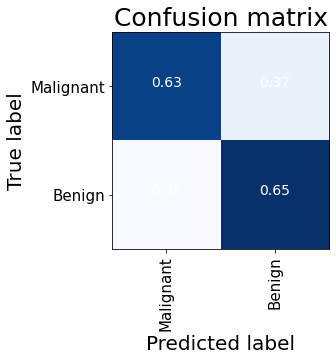

In [ ]:
test_loss, test_accuracy = model19.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model19.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model19.save(os.path.join(dir_name, network_name))

6/6 [==============================] - 1s 129ms/step - loss: 0.6152 - acc: 0.6696
0.6696428656578064
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       117
           1       0.76      0.72      0.74       219

    accuracy                           0.67       336
   macro avg       0.64      0.65      0.64       336
weighted avg       0.68      0.67      0.67       336



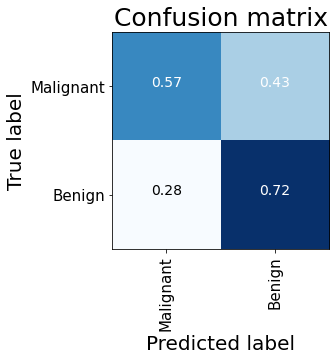

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

### Fine Tuning


In [ ]:
conv_base19.trainable = True

set_trainable = False
for layer in conv_base19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    elif layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model19.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-7),
              metrics=['acc'])

In [ ]:
conv_base19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 24,219,713
Trainable params: 21,894,145
Non-trainable params: 2,325,568
_________________________________________________________________


In [ ]:
history19 = model19.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)]
      )

Epoch 1/100
34/34 [==============================] - 16s 426ms/step - loss: 0.5249 - acc: 0.7340 - val_loss: 0.5829 - val_acc: 0.6884
Epoch 2/100
34/34 [==============================] - 14s 398ms/step - loss: 0.5302 - acc: 0.7184 - val_loss: 0.5844 - val_acc: 0.6903
Epoch 3/100
34/34 [==============================] - 14s 401ms/step - loss: 0.5341 - acc: 0.7176 - val_loss: 0.5852 - val_acc: 0.6922
Epoch 4/100
34/34 [==============================] - 14s 399ms/step - loss: 0.5290 - acc: 0.7235 - val_loss: 0.5851 - val_acc: 0.6903
Epoch 5/100
34/34 [==============================] - 14s 398ms/step - loss: 0.5293 - acc: 0.7219 - val_loss: 0.5831 - val_acc: 0.6903
Epoch 6/100
34/34 [==============================] - 14s 398ms/step - loss: 0.5092 - acc: 0.7444 - val_loss: 0.5865 - val_acc: 0.6903
Epoch 7/100
34/34 [==============================] - 14s 397ms/step - loss: 0.5212 - acc: 0.7199 - val_loss: 0.5862 - val_acc: 0.6884
Epoch 8/100
34/34 [==============================] - 14s 398ms

### MODEL EVALUATION (VGG19-FT)

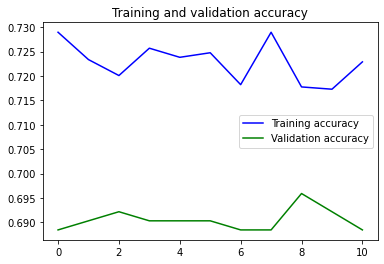

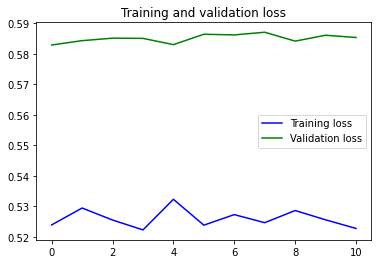

In [ ]:
import matplotlib.pyplot as plt

acc = history19.history['acc']
val_acc = history19.history['val_acc']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

6/6 [==============================] - 1s 126ms/step - loss: 0.6047 - acc: 0.6994
0.699404776096344
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       117
           1       0.77      0.78      0.77       219

    accuracy                           0.70       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.70      0.70       336



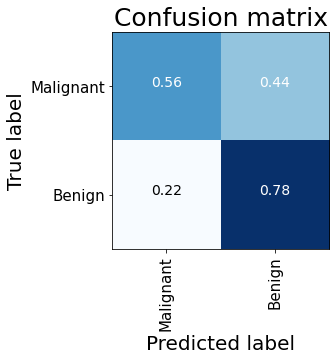

In [ ]:
test_loss, test_accuracy = model19.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model19.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model19.save(os.path.join(dir_name, 'VGG19_finetuned2.h5'))

## **3.2.3: VGG16 + CLASS WEIGHTING + INITIAL BIAS, USING 3-STAGE TRAINING STRATEGY**

3-stage training strategy inspired by: <br>Deep Learning to Improve Breast
Cancer Detection on Screening
Mammography<br>
Li Shen, Laurie R. Margolies, Joseph H. Rothstein, Eugene Fluder, Russell McBride &
Weiva Sieh

In [ ]:
#Since all partitioned sets have a  40~/60~ split we can use the test set for class weight and initial bias determination.
weight_for_0 = (1 / train_class0)*(train_class0+train_class1)/2.0 
weight_for_1 = (1 / train_class1)*(train_class0+train_class1)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
output_bias=np.log([train_class0/train_class1])
init_bias= tf.keras.initializers.Constant(output_bias)

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print(output_bias)

Weight for class 0: 1.20
Weight for class 1: 0.86
[-0.33390936]


### Stage 1: Feature Extraction

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)                
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid',bias_initializer=init_bias))

In [ ]:
#Name the model 
network_name = 'VGG16_featextraction_weighted.h5'
network_name_best = 'VGG16_featextraction_weighted_best.h5'

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = "val_loss", mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=3,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      class_weight=class_weight,
      callbacks=[my_callback]
      )

Epoch 1/3
66/66 [==============================] - 12s 178ms/step - loss: 0.6984 - acc: 0.5113 - val_loss: 0.6444 - val_acc: 0.6484
Epoch 2/3
66/66 [==============================] - 12s 178ms/step - loss: 0.6483 - acc: 0.5922 - val_loss: 0.6709 - val_acc: 0.5605
Epoch 3/3
66/66 [==============================] - 12s 178ms/step - loss: 0.6369 - acc: 0.6128 - val_loss: 0.7234 - val_acc: 0.4902


### MODEL EVALUATION (VGG16-FE)

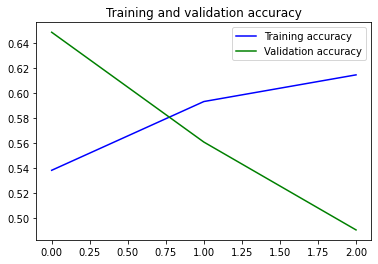

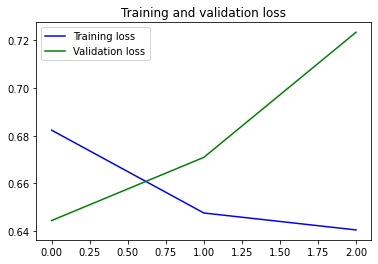

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 1s 64ms/step - loss: 0.7884 - acc: 0.4167
0.4166666567325592
              precision    recall  f1-score   support

           0       0.37      0.97      0.54       117
           1       0.87      0.12      0.22       219

    accuracy                           0.42       336
   macro avg       0.62      0.54      0.38       336
weighted avg       0.70      0.42      0.33       336



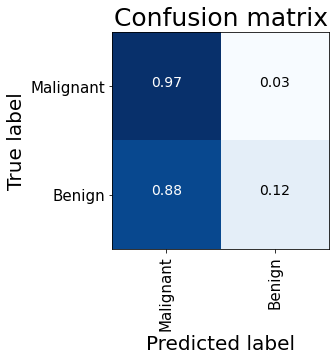

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

11/11 [==============================] - 1s 63ms/step - loss: 0.6501 - acc: 0.6220
0.6220238208770752


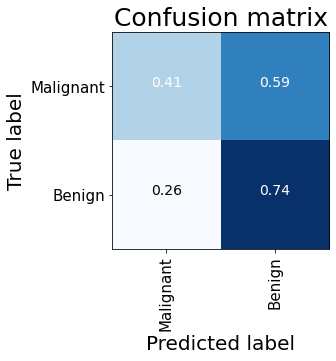

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")


###Stage 2: Tuning last block of VGG16


In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 7,342,593
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=10,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      class_weight=class_weight,
      callbacks=[my_callback]
      )

Epoch 1/10
66/66 [==============================] - 13s 184ms/step - loss: 0.7465 - acc: 0.5628 - val_loss: 0.6039 - val_acc: 0.6621
Epoch 2/10
66/66 [==============================] - 12s 185ms/step - loss: 0.6130 - acc: 0.6179 - val_loss: 0.5806 - val_acc: 0.6836
Epoch 3/10
66/66 [==============================] - 12s 186ms/step - loss: 0.6168 - acc: 0.6199 - val_loss: 0.5752 - val_acc: 0.6992
Epoch 4/10
66/66 [==============================] - 12s 186ms/step - loss: 0.5872 - acc: 0.6796 - val_loss: 0.6408 - val_acc: 0.5371
Epoch 5/10
66/66 [==============================] - 12s 182ms/step - loss: 0.6034 - acc: 0.6126 - val_loss: 0.5620 - val_acc: 0.6758
Epoch 6/10
66/66 [==============================] - 12s 185ms/step - loss: 0.5804 - acc: 0.6533 - val_loss: 0.6055 - val_acc: 0.6328
Epoch 7/10
66/66 [==============================] - 12s 182ms/step - loss: 0.5981 - acc: 0.6273 - val_loss: 0.5656 - val_acc: 0.6816
Epoch 8/10
66/66 [==============================] - 12s 182ms/step - 

### MODEL EVALUATION (VGG16-FT1)

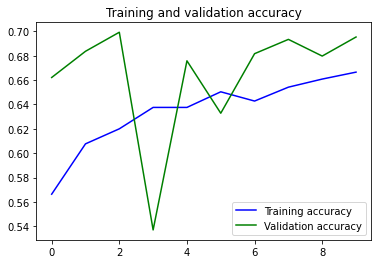

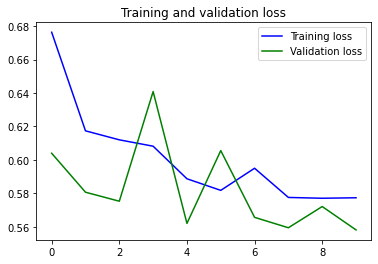

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 1s 67ms/step - loss: 0.5973 - acc: 0.6726
0.6726190447807312
              precision    recall  f1-score   support

           0       0.54      0.44      0.48       117
           1       0.73      0.80      0.76       219

    accuracy                           0.67       336
   macro avg       0.63      0.62      0.62       336
weighted avg       0.66      0.67      0.66       336



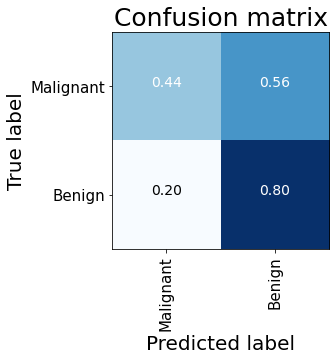

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'VGG16_finetuned.h5'))

###Stage 3: Tuning the whole VGG16 network


In [ ]:
conv_base.trainable = True

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=37,
      validation_data = validation_dataset,
      validation_steps=total_val // BATCH_SIZE,
      class_weight=class_weight,
      callbacks=[my_callback]
      )

Epoch 1/37
66/66 [==============================] - 19s 258ms/step - loss: 0.5950 - acc: 0.6289 - val_loss: 0.5668 - val_acc: 0.6934
Epoch 2/37
66/66 [==============================] - 16s 244ms/step - loss: 0.5724 - acc: 0.6460 - val_loss: 0.5742 - val_acc: 0.6875
Epoch 3/37
66/66 [==============================] - 16s 244ms/step - loss: 0.5586 - acc: 0.6893 - val_loss: 0.5786 - val_acc: 0.6875
Epoch 4/37
66/66 [==============================] - 16s 241ms/step - loss: 0.5305 - acc: 0.6897 - val_loss: 0.5590 - val_acc: 0.7148
Epoch 5/37
66/66 [==============================] - 16s 241ms/step - loss: 0.5131 - acc: 0.7111 - val_loss: 0.5516 - val_acc: 0.7266
Epoch 6/37
66/66 [==============================] - 16s 245ms/step - loss: 0.5020 - acc: 0.7217 - val_loss: 0.5982 - val_acc: 0.6465
Epoch 7/37
66/66 [==============================] - 16s 244ms/step - loss: 0.5323 - acc: 0.7017 - val_loss: 0.6238 - val_acc: 0.6562
Epoch 8/37
66/66 [==============================] - 16s 243ms/step - 

### MODEL EVALUATION (VGG16-FT2)

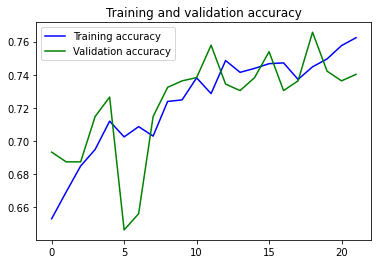

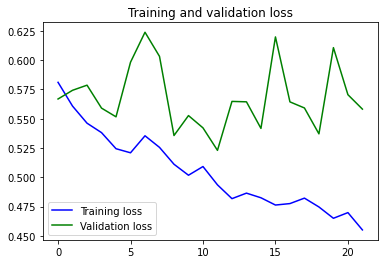

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

11/11 [==============================] - 1s 66ms/step - loss: 0.5991 - acc: 0.7173
0.7172619104385376
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       117
           1       0.80      0.76      0.78       219

    accuracy                           0.72       336
   macro avg       0.69      0.70      0.69       336
weighted avg       0.72      0.72      0.72       336



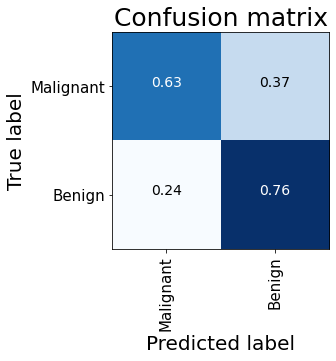

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'VGG16_finetuned3step.h5'))

11/11 [==============================] - 1s 65ms/step - loss: 0.6488 - acc: 0.6339
0.6339285969734192
              precision    recall  f1-score   support

           0       0.48      0.74      0.59       117
           1       0.81      0.58      0.67       219

    accuracy                           0.63       336
   macro avg       0.65      0.66      0.63       336
weighted avg       0.69      0.63      0.64       336



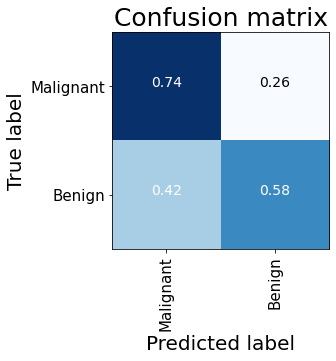

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
model_best = keras.models.load_model(os.path.join(path, network_name_best))


test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))